# ***Gradient Boosting Decision Tree 梯度提升树***

# QA
----
## **1. 介绍一下GBDT**
### GBDT（GradientBoostingDecisionTree）是一种迭代的决策树算法，该算法由多棵决策树组成，属于Boosting策略，使用回归树，每一棵树都以之前树得到的残差来更新目标值，预测值和实际值的残差与损失函数的负梯度相同，这样每一棵树的值加起来即为GBDT的预测值。GBDT是被公认的泛化能力较强的算法。优点是可以自动进行特征组合，拟合非线性数据，可以灵活处理各种类型的数据；缺点是对异常点敏感。

-----

## **2. xgboost有哪些改进？**
### a. xgb提高了模型精度，且能够够自定义损失函数，这是因为对于损失函数的处理gbdt只用到一节泰勒展开，而xgb进行了二阶泰勒展开。
### b. xgb同时支持决策树和线性分类器，非常灵活。
### c. xgb目标函数加入了正则项来控制模型复杂度，可以降低过拟合。
### d. xgb采用了shrinkage策略，不直接更新每棵树的权重，而是乘以学习率，能够提高精度。
### e. 列抽样：XGBoost借鉴了随机森林的做法，支持列抽样，不仅能降低过拟合，还能减少计算
### f. 缺失值处理：XGBoost采用的稀疏感知算法极大的加快了节点分裂的速度；
### g. 可以并行化操作：块结构可以很好的支持并行计算。

----

## **3.GBDT与随机森林的异同点？**
### a. gbdt是boosting策略，而随机森林是bagging策略，前者关注降低偏差，后者关注降低方差。gbdt的决策树在不断迭代，因此需要较简单的模型来控制方差，而rf并行使用多个决策树，能有效降低方差，因此需要较复杂的模型来控制偏差。
### b. gbdt和rf同属于集成学习的范畴；gbdt和rf都采用bootstrap思想，进行有放回抽样，但前者根据错误率抽样，而后者是随机均匀抽样。
### c. rf的树可以是分类树也可以是回归树，而gbdt只能是回归树。
### d. rf的预测采用多数投票，而gbdt使用求和
### e. 随机森林对异常值不敏感，gbdt对异常值非常敏感


----

## **4. xgb防止过拟合有什么方法，如何调参？**
### a. xgb引入了目标函数的正则项，通过调整其中的gamma和lambda常数能一定程度抑制过拟合
### b. xgb借鉴了随机森林的做法，支持列抽样。训练时，对训练数据进行采样的比例是subsample参数。colsample_bytree, colsample_bylevel, colsample_bynode，则是每颗树/每层/每个节点是否采样。对特征进行采样不仅能降低过拟合，还能减少计算
### c. xgb的shrinkage策略，通过eta参数控制学习率,但是需要增加num_boost_round(提升迭代的次数，也就是生成多少基模型)来平衡步长因子的减小。
### d. xgb的决策树深度max_depth,控制树深度可以抑制过拟合
### e. 设置early_stopping_rounds，早期停止次数。假设为100，验证集的误差在100次迭代内不能再继续降低时，就停止迭代。

----

## **5. xgb为什么对缺失值不敏感，如何处理缺失值的？**
### 树模型对缺失值的敏感度低，大部分时候可以在数据缺失时时使用。原因就是，一棵树中每个结点在分裂时，寻找的是某个特征的最佳分裂点（特征值），完全可以不考虑存在特征值缺失的样本，也就是说，如果某些样本缺失的特征值缺失，对寻找最佳分割点的影响不是很大。另外XGBoost在构建树的节点过程中只考虑非缺失值的数据遍历，而为每个节点增加了一个缺省方向，当样本相应的特征值缺失时，可以被归类到缺省方向上，最优的缺省方向可以从数据中学到。模型分别枚举特征缺省的样本归为左右分支后的增益，选择增益最大的枚举项即为最优缺省方向.

----
## **6. 解释一下GBDT沿着梯度下降方向提升，如何实现的？**
### GBDT在每一轮迭代学习回归树的时候，拟合目标即残差，就是损失函数L对当前所学模型F预测值的负梯度，所以模型的更新是沿着梯度下降方向的。



# ***Titanic***
## test survival on the Titanic
----
### 尝试用lightgbm提交预测结果，并调整模型参数提升成绩
### 尝试在案例基础上新增特征，提高score



In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA


----
## 1. 在1.2处理好的数据基础上进行随机森林分类
### 观察并选择特征，做好处理。进行随机森林分类并调优。

In [2]:
train=pd.read_csv('train_processed.csv')
test=pd.read_csv('test_processed.csv')

In [3]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [4]:
test.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [5]:
pca=PCA(n_components=1)
ncol=pca.fit_transform(train[['SibSp','Parch']])
train["Companion"]=ncol
pca=PCA(n_components=1)
ncol=pca.fit_transform(test[['SibSp','Parch']])
test["Companion"]=ncol

In [6]:
df_train = pd.get_dummies(train, columns=["Pclass","Embarked","Sex"])
df_train.drop('Sex_female', axis=1, inplace=True)
df_train.drop('PassengerId', axis=1, inplace=True)
df_train.drop('Ticket', axis=1, inplace=True)
df_train.drop('SibSp', axis=1, inplace=True)
df_train.drop('Parch', axis=1, inplace=True)

In [7]:

df_test = pd.get_dummies(test, columns=["Pclass","Embarked","Sex"])
df_test.drop('Sex_female', axis=1, inplace=True)
df_test.drop('PassengerId', axis=1, inplace=True)
df_test.drop('Ticket', axis=1, inplace=True)
df_test.drop('SibSp', axis=1, inplace=True)
df_test.drop('Parch', axis=1, inplace=True)


In [25]:
df_train

,Survived,Age,Fare,Companion,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0.259128,0,0,1,0,0,1,1
1,1,38.0,71.2833,0.259128,1,0,0,1,0,0,0
2,1,26.0,7.9250,-0.637826,0,0,1,0,0,1,0
3,1,35.0,53.1000,0.259128,1,0,0,0,0,1,0
4,0,35.0,8.0500,-0.637826,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,13.0000,-0.637826,0,1,0,0,0,1,1
887,1,19.0,30.0000,-0.637826,1,0,0,0,0,1,0
888,0,27.0,23.4500,1.143377,0,0,1,0,0,1,0
889,1,26.0,30.0000,-0.637826,1,0,0,1,0,0,1


In [9]:
df_test

,Age,Fare,Companion,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,34.5,7.8292,-0.582143,0,0,1,0,1,0,1
1,47.0,7.0000,0.016856,0,0,1,0,0,1,0
2,62.0,9.6875,-0.582143,0,1,0,0,1,0,1
3,27.0,8.6625,-0.582143,0,0,1,0,0,1,1
4,22.0,12.2875,0.817606,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
413,29.0,8.0500,-0.582143,0,0,1,0,0,1,1
414,39.0,108.9000,-0.582143,1,0,0,1,0,0,0
415,38.5,7.2500,-0.582143,0,0,1,0,0,1,1
416,29.0,8.0500,-0.582143,0,0,1,0,0,1,1


----
引入lightgbm

In [2]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.model_selection import train_test_split


In [126]:
def prepare_for_light_gbm(data,id_col,drop_cols,target_col):
    # Drop target column
    if target_col is not None:
        labels = data[target_col]
        drop_cols = drop_cols + [target_col]
    else:
        labels = []

    if id_col is not None:
        ids = data[id_col]
        drop_cols = drop_cols + [id_col]
    else:
        ids = []

    if drop_cols is not None:
        data = data.drop(drop_cols, axis=1)

    # Create LGB mats
    lgb_data = lgb.Dataset(data, label=labels, free_raw_data=False,
                           feature_name=list(data.columns), 
                           categorical_feature='auto')

    return lgb_data, labels, ids, data



In [129]:
train_split_df, valid_split_df = train_test_split(df_train, test_size=0.4)

(train_lgb_dataset, train_labels,
     train_ids, train_split_df) = prepare_for_light_gbm(
        train_split_df,drop_cols=[],id_col=None, target_col='Survived')

(valid_lgb_dataset, valid_labels,
     valid_ids, valid_split_df) = prepare_for_light_gbm(
        valid_split_df,drop_cols=[], id_col=None,target_col='Survived')

test_lgb_dataset, _, _, test_df = prepare_for_light_gbm(
        df_test,drop_cols=[],id_col=None, target_col=None)

    # Prepare data set using all the training data
(train_valid_lgb_dataset, train_valid_labels,
     _, train_valid_df) = prepare_for_light_gbm(
        df_train,drop_cols=[],id_col=None, target_col='Survived')

In [130]:
params = {'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 
              'num_leaves': 64, 'learning_rate': 0.05, 'max_bin': 512, 
              'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1,
              'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 10, 
              'min_split_gain': 0.5, 'min_child_weight': 1, 
              'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 
              'metric': 'binary_error'}
    # Create parameters to search
grid_params = {'learning_rate': [0.01], 'n_estimators': [8, 16, 24, 32],
                   'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'], 
                   'objective': ['binary'], 'seed': [500],
                   'colsample_bytree': [0.65, 0.75, 0.8], 
                   'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
                   'reg_lambda': [1, 2, 6]}

    # Create classifier to use. Note that parameters have to be input manually
    # not as a dict!
mod = lgb.LGBMClassifier(**params)

    # To view the default model params:
mod.get_params().keys()

    # Create the grid
grid = GridSearchCV(mod, param_grid=grid_params, cv=5, verbose=1, n_jobs=-1)
    # Run the grid
grid.fit(train_valid_df, train_valid_labels)

    # Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

    # Using parameters already set above, replace in the best from the grid search






Fitting 5 folds for each of 864 candidates, totalling 4320 fits


D:\programs\envs\python36\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan 

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: Sex, Embarked, Title

In [97]:

best_params = {k: grid.best_params_.get(k, v) for k, v in params.items()}
best_params['verbosity'] = -1
valid_preds, train_preds, test_preds = 0, 0, 0
for m in range(k):
        print('Fitting model', m)

        # Prepare the data set for fold
        train_split_df, valid_split_df = train_test_split(df_train, 
                                                          test_size=0.4)
        (train_lgb_dataset, train_labels,
         train_ids, train_split_df) = prepare_for_light_gbm(
            train_split_df, target_col='Survived', id_col=None,
            drop_cols=[])
        
        (valid_lgb_dataset, valid_labels,
         valid_ids, valid_split_df) = prepare_for_light_gbm(
            valid_split_df, target_col='Survived', id_col=None,
            drop_cols=[])
        
        # Train
gbm = lgb.train(best_params, train_lgb_dataset, num_boost_round=100000,
                        valid_sets=[train_lgb_dataset, valid_lgb_dataset],
                        early_stopping_rounds=50, verbose_eval=50)

Fitting model 0
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.191011	valid_1's binary_error: 0.246499
[100]	training's binary_error: 0.164794	valid_1's binary_error: 0.229692
[150]	training's binary_error: 0.157303	valid_1's binary_error: 0.218487
[200]	training's binary_error: 0.157303	valid_1's binary_error: 0.215686
Early stopping, best iteration is:
[181]	training's binary_error: 0.157303	valid_1's binary_error: 0.215686


In [98]:
result = gbm.predict(df_test, num_iteration=gbm.best_iteration) 


result = np.int32(result > 0.5)
temp=pd.read_csv('test.csv')
submission={'PassengerId':temp.PassengerId,'Survived':result}
df_submission=pd.DataFrame(submission)
df_submission.to_csv('submission_10.csv', index=False)


In [14]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# scaler = StandardScaler()
# y = df_train.Survived
# df_train = scaler.fit_transform(df_train.drop('Survived',axis=1))
# df_test = scaler.transform(df_test)
# X = df_train


----
## 2. 添加特征提高分数
### 添加是否特殊头衔头衔，是否成年两个特征


In [85]:
df_train

,Survived,Age,Fare,Companion,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0.259128,0,0,1,0,0,1,1
1,1,38.0,71.2833,0.259128,1,0,0,1,0,0,0
2,1,26.0,7.9250,-0.637826,0,0,1,0,0,1,0
3,1,35.0,53.1000,0.259128,1,0,0,0,0,1,0
4,0,35.0,8.0500,-0.637826,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,13.0000,-0.637826,0,1,0,0,0,1,1
887,1,19.0,30.0000,-0.637826,1,0,0,0,0,1,0
888,0,27.0,23.4500,1.143377,0,0,1,0,0,1,0
889,1,26.0,30.0000,-0.637826,1,0,0,1,0,0,1


In [86]:
df_test

,Age,Fare,Companion,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,34.5,7.8292,-0.582143,0,0,1,0,1,0,1
1,47.0,7.0000,0.016856,0,0,1,0,0,1,0
2,62.0,9.6875,-0.582143,0,1,0,0,1,0,1
3,27.0,8.6625,-0.582143,0,0,1,0,0,1,1
4,22.0,12.2875,0.817606,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
413,29.0,8.0500,-0.582143,0,0,1,0,0,1,1
414,39.0,108.9000,-0.582143,1,0,0,1,0,0,0
415,38.5,7.2500,-0.582143,0,0,1,0,0,1,1
416,29.0,8.0500,-0.582143,0,0,1,0,0,1,1


In [86]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
name_train = train.Name.values
name_test = test.Name.values
title_list=set(['Sir.', 'Lady.', 'Master.','Don.', 'Rev.', 'Dr.'])
def get_title(name):
    name=name.split(' ')
    join=set(name) & title_list
    if  join:
        return 1
    else:
        return 0

title_train = [get_title(name) for name in name_train]
title_test = [get_title(name) for name in name_test]
df_train['Title'] = title_train
df_test['Title']= title_test

In [91]:
age_train = df_train.Age.values
age_test = df_test.Age.values

def is_adult(age):
    if  age>=18:
        return 1
    else:
        return 0
is_adult_train = [is_adult(age) for age in age_train]
is_adult_test = [is_adult(age) for age in age_test]
df_train['is_adult'] = is_adult_train
df_test['is_adult']= is_adult_test

In [101]:
df_train

,Survived,Age,Fare,Companion,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male,Title,is_adult
0,0,22.0,7.2500,0.259128,0,0,1,0,0,1,1,0,1
1,1,38.0,71.2833,0.259128,1,0,0,1,0,0,0,0,1
2,1,26.0,7.9250,-0.637826,0,0,1,0,0,1,0,0,1
3,1,35.0,53.1000,0.259128,1,0,0,0,0,1,0,0,1
4,0,35.0,8.0500,-0.637826,0,0,1,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,13.0000,-0.637826,0,1,0,0,0,1,1,1,1
887,1,19.0,30.0000,-0.637826,1,0,0,0,0,1,0,0,1
888,0,27.0,23.4500,1.143377,0,0,1,0,0,1,0,0,1
889,1,26.0,30.0000,-0.637826,1,0,0,1,0,0,1,0,1


In [100]:
df_test

,Age,Fare,Companion,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male,Title,is_adult
0,34.5,7.8292,-0.582143,0,0,1,0,1,0,1,0,1
1,47.0,7.0000,0.016856,0,0,1,0,0,1,0,0,1
2,62.0,9.6875,-0.582143,0,1,0,0,1,0,1,0,1
3,27.0,8.6625,-0.582143,0,0,1,0,0,1,1,0,1
4,22.0,12.2875,0.817606,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,29.0,8.0500,-0.582143,0,0,1,0,0,1,1,0,1
414,39.0,108.9000,-0.582143,1,0,0,1,0,0,0,0,1
415,38.5,7.2500,-0.582143,0,0,1,0,0,1,1,0,1
416,29.0,8.0500,-0.582143,0,0,1,0,0,1,1,0,1


----
## 3. 重新处理分类变量并提高estimator数量
### 提交分数没有变化。既然lightgbm原生支持分类特征，那么重新处理数据，对lightgbm设定好哪些是分类变量，不再使用独热码。

In [118]:
from sklearn.preprocessing import LabelEncoder

In [119]:
df_train = pd.read_csv('train_processed.csv')
df_test = pd.read_csv('test_processed.csv')

In [120]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
name_train = train.Name.values
name_test = test.Name.values
title_list=set(['Mr.','Miss.','Mrs.','Miss.','Sir.', 'Lady.', 'Master.','Don.', 'Rev.', 'Dr.'])
def get_title(name):
    name=name.split(' ')
    join=set(name) & title_list
    if  join:
        return list(join)[0]
    else:
        return 'None'

title_train = [get_title(name) for name in name_train]
title_test = [get_title(name) for name in name_test]
df_train['Title'] = title_train
df_test['Title']= title_test

In [121]:
pca=PCA(n_components=1)
ncol=pca.fit_transform(train[['SibSp','Parch']])
df_train["Companion"]=ncol
pca=PCA(n_components=1)
ncol=pca.fit_transform(test[['SibSp','Parch']])
df_test["Companion"]=ncol

In [122]:

df_train.drop('PassengerId', axis=1, inplace=True)
df_train.drop('Ticket', axis=1, inplace=True)
df_train.drop('SibSp', axis=1, inplace=True)
df_train.drop('Parch', axis=1, inplace=True)

df_test.drop('PassengerId', axis=1, inplace=True)
df_test.drop('Ticket', axis=1, inplace=True)
df_test.drop('SibSp', axis=1, inplace=True)
df_test.drop('Parch', axis=1, inplace=True)


In [123]:
age_train = df_train.Age.values
age_test = df_test.Age.values

def is_adult(age):
    if  age>=18:
        return 1
    else:
        return 0
is_adult_train = [is_adult(age) for age in age_train]
is_adult_test = [is_adult(age) for age in age_test]
df_train['is_adult'] = is_adult_train
df_test['is_adult']= is_adult_test

In [124]:
df_train = pd.get_dummies(df_train, columns=["Sex"])
df_train.drop('Sex_female', axis=1, inplace=True)
df_test = pd.get_dummies(df_test, columns=["Sex"])
df_test.drop('Sex_female', axis=1, inplace=True)

In [125]:

le = LabelEncoder()
for feature in ['Embarked', 'Title','is_adult']:
    df_train[feature]=le.fit_transform(df_train[feature])
    df_test[feature]=le.transform(df_test[feature])


In [126]:
df_train

,Survived,Pclass,Age,Fare,Embarked,Title,Companion,is_adult,Sex_male
0,0,3,22.0,7.2500,2,5,0.259128,1,1
1,1,1,38.0,71.2833,0,6,0.259128,1,0
2,1,3,26.0,7.9250,2,4,-0.637826,1,0
3,1,1,35.0,53.1000,2,6,0.259128,1,0
4,0,3,35.0,8.0500,2,5,-0.637826,1,1
...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,13.0000,2,8,-0.637826,1,1
887,1,1,19.0,30.0000,2,4,-0.637826,1,0
888,0,3,27.0,23.4500,2,4,1.143377,1,0
889,1,1,26.0,30.0000,0,5,-0.637826,1,1


In [127]:
def prepare_for_light_gbm(data,id_col,drop_cols,target_col):
    # Drop target column
    if target_col is not None:
        labels = data[target_col]
        drop_cols = drop_cols + [target_col]
    else:
        labels = []

    if id_col is not None:
        ids = data[id_col]
        drop_cols = drop_cols + [id_col]
    else:
        ids = []

    if drop_cols is not None:
        data = data.drop(drop_cols, axis=1)

    # Create LGB mats
    lgb_data = lgb.Dataset(data, label=labels, free_raw_data=False,
                           feature_name=list(data.columns), 
                           categorical_feature='auto')

    return lgb_data, labels, ids, data

train_split_df, valid_split_df = train_test_split(df_train, test_size=0.4)
columns_to_drop = ['Ticket', 'Cabin', 'Name']
(train_lgb_dataset, train_labels,
     train_ids, train_split_df) = prepare_for_light_gbm(
        train_split_df,drop_cols=[],id_col=None, target_col='Survived')

(valid_lgb_dataset, valid_labels,
     valid_ids, valid_split_df) = prepare_for_light_gbm(
        valid_split_df,drop_cols=[], id_col=None,target_col='Survived')

test_lgb_dataset, _, _, test_df = prepare_for_light_gbm(
        df_test,drop_cols=[],id_col=None, target_col=None)

    # Prepare data set using all the training data
(train_valid_lgb_dataset, train_valid_labels,
     _, train_valid_df) = prepare_for_light_gbm(
        df_train,drop_cols=[],id_col=None, target_col='Survived')

In [111]:
params = {'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 
              'num_leaves': 64, 'learning_rate': 0.05, 'max_bin': 512, 
              'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1,
              'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 10, 
              'min_split_gain': 0.5, 'min_child_weight': 1, 
              'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 
              'metric': 'binary_error','categorical_feature':[3,4,6,7],'lambda_l2':0.1}
    # Create parameters to search
grid_params = {'learning_rate': [0.01], 'n_estimators': [8,16,32,48],
                   'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'], 
                   'objective': ['binary'], 'seed': [500],
                   'colsample_bytree': [0.65, 0.75, 0.8], 
                   'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
                   'reg_lambda': [1, 2, 6]}

    # Create classifier to use. Note that parameters have to be input manually
    # not as a dict!
mod = lgb.LGBMClassifier(**params)

    # To view the default model params:
mod.get_params().keys()

    # Create the grid
grid = GridSearchCV(mod, param_grid=grid_params, cv=5, verbose=1, n_jobs=-1)
    # Run the grid
grid.fit(train_valid_df, train_valid_labels)

    # Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=1 will be ignored. Current value: lambda_l2=0.1
{'boosting_type': 'gbdt', 'colsample_bytree': 0.75, 'learning_rate': 0.01, 'n_estimators': 48, 'num_leaves': 16, 'objective': 'binary', 'reg_alpha': 1, 'reg_lambda': 1, 'seed': 500, 'subsample': 0.75}
0.8013935095097608


D:\programs\envs\python36\lib\site-packages\lightgbm\basic.py:1077: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


Fitting model 0
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.187266	valid_1's binary_error: 0.226891
[100]	training's binary_error: 0.155431	valid_1's binary_error: 0.218487
[150]	training's binary_error: 0.142322	valid_1's binary_error: 0.187675
Early stopping, best iteration is:
[126]	training's binary_error: 0.146067	valid_1's binary_error: 0.179272


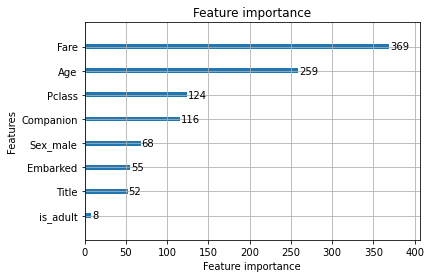

Fitting model 1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=1 will be ignored. Current value: lambda_l2=0.1
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.217228	valid_1's binary_error: 0.210084
[100]	training's binary_error: 0.161049	valid_1's binary_error: 0.184874
[150]	training's binary_error: 0.140449	valid_1's binary_error: 0.196078
Early stopping, best iteration is:
[110]	training's binary_error: 0.151685	valid_1's binary_error: 0.176471


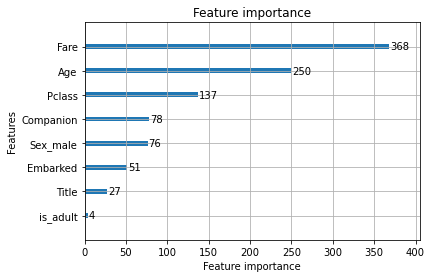

Fitting model 2
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=1 will be ignored. Current value: lambda_l2=0.1
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.187266	valid_1's binary_error: 0.22409
[100]	training's binary_error: 0.123596	valid_1's binary_error: 0.193277
Early stopping, best iteration is:
[80]	training's binary_error: 0.127341	valid_1's binary_error: 0.184874


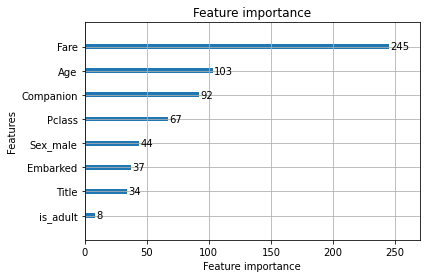

Fitting model 3
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=1 will be ignored. Current value: lambda_l2=0.1
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.187266	valid_1's binary_error: 0.2493
[100]	training's binary_error: 0.132959	valid_1's binary_error: 0.212885
[150]	training's binary_error: 0.131086	valid_1's binary_error: 0.212885
Early stopping, best iteration is:
[103]	training's binary_error: 0.131086	valid_1's binary_error: 0.207283


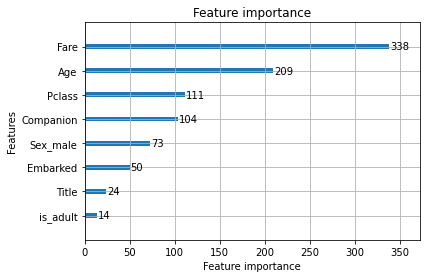

Fitting model 4
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=1 will be ignored. Current value: lambda_l2=0.1
Training until validation scores don't improve for 50 rounds
[50]	training's binary_error: 0.189139	valid_1's binary_error: 0.254902
[100]	training's binary_error: 0.144195	valid_1's binary_error: 0.240896
[150]	training's binary_error: 0.136704	valid_1's binary_error: 0.212885
[200]	training's binary_error: 0.123596	valid_1's binary_error: 0.179272
Early stopping, best iteration is:
[197]	training's binary_error: 0.123596	valid_1's binary_error: 0.179272


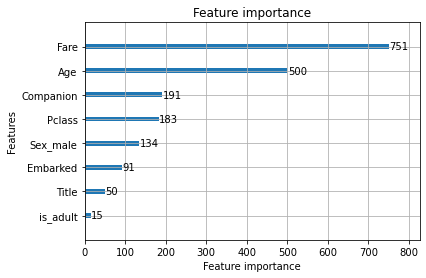

In [112]:
best_params = {k: grid.best_params_.get(k, v) for k, v in params.items()}
best_params['verbosity'] = -1
k = 5
valid_preds, train_preds, result = 0, 0, 0
for m in range(k):
    
    print('Fitting model', m)

        # Prepare the data set for fold
    train_split_df, valid_split_df = train_test_split(df_train, 
                                                          test_size=0.4)
    (train_lgb_dataset, train_labels,train_ids, train_split_df) = prepare_for_light_gbm(
            train_split_df, target_col='Survived', id_col=None,
            drop_cols=[])
        
    (valid_lgb_dataset, valid_labels,valid_ids, valid_split_df) = prepare_for_light_gbm(
            valid_split_df, target_col='Survived', id_col=None,
            drop_cols=[])
        
        # Train
    gbm = lgb.train(best_params, train_lgb_dataset, num_boost_round=100000,
                        valid_sets=[train_lgb_dataset, valid_lgb_dataset],
                        early_stopping_rounds=50, verbose_eval=50)

        # Plot importance
    lgb.plot_importance(gbm)
    plt.show()

        # Predict
    valid_preds += gbm.predict(valid_split_df, 
                                   num_iteration=gbm.best_iteration) / k
    train_preds += gbm.predict(train_split_df, 
                                   num_iteration=gbm.best_iteration) / k
    result += gbm.predict(test_df, num_iteration=gbm.best_iteration) / k 





In [113]:
# result = np.int32(result > 0.5)
# temp=pd.read_csv('test.csv')
# submission={'PassengerId':temp.PassengerId,'Survived':result}
# df_submission=pd.DataFrame(submission)
# df_submission.to_csv('submission_19.csv', index=False)

----

In [114]:
train1=pd.read_csv('train_processed.csv')
test1=pd.read_csv('test_processed.csv')
pca=PCA(n_components=1)
ncol=pca.fit_transform(train1[['SibSp','Parch']])
train1["Companion"]=ncol
pca=PCA(n_components=1)
ncol=pca.fit_transform(test1[['SibSp','Parch']])
test1["Companion"]=ncol
df_train1 = pd.get_dummies(train1, columns=["Pclass","Embarked","Sex"])
df_train1.drop('Sex_female', axis=1, inplace=True)
df_train1.drop('PassengerId', axis=1, inplace=True)
df_train1.drop('Ticket', axis=1, inplace=True)
df_train1.drop('SibSp', axis=1, inplace=True)
df_train1.drop('Parch', axis=1, inplace=True)
df_test1 = pd.get_dummies(test1, columns=["Pclass","Embarked","Sex"])
df_test1.drop('Sex_female', axis=1, inplace=True)
df_test1.drop('PassengerId', axis=1, inplace=True)
df_test1.drop('Ticket', axis=1, inplace=True)
df_test1.drop('SibSp', axis=1, inplace=True)
df_test1.drop('Parch', axis=1, inplace=True)
picked_features = ['Age', 'Companion', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_male']\

from sklearn.preprocessing import StandardScaler
X1 = df_train1[picked_features]
y = df_train1.Survived
df_test1=df_test1[picked_features]
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
df_test1 = scaler.transform(df_test1)


from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X1, y)
result1=model.predict_proba(df_test1)[:,1]
temp=pd.read_csv('test.csv')
submission={'PassengerId':temp.PassengerId,'Survived':result1}
df_submission=pd.DataFrame(submission)
df_submission.to_csv('prob_logistic.csv')


----

In [ ]:
train=pd.read_csv('train_processed.csv')
test=pd.read_csv('test_precessed.csv')
train.isnull().sum()
test.isnull().sum()
pca=PCA(n_components=1)
ncol=pca.fit_transform(train[['SibSp','Parch']])
train["Companion"]=ncol
pca=PCA(n_components=1)
ncol=pca.fit_transform(test[['SibSp','Parch']])
test["Companion"]=ncol

df_train = pd.get_dummies(train, columns=["Pclass","Embarked","Sex"])
df_train.drop('Sex_female', axis=1, inplace=True)
df_train.drop('PassengerId', axis=1, inplace=True)
df_train.drop('Ticket', axis=1, inplace=True)
df_train.drop('SibSp', axis=1, inplace=True)
df_train.drop('Parch', axis=1, inplace=True)

df_test = pd.get_dummies(test, columns=["Pclass","Embarked","Sex"])
df_test.drop('Sex_female', axis=1, inplace=True)
df_test.drop('PassengerId', axis=1, inplace=True)
df_test.drop('Ticket', axis=1, inplace=True)
df_test.drop('SibSp', axis=1, inplace=True)
df_test.drop('Parch', axis=1, inplace=True)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

scaler = StandardScaler()
y = df_train.Survived
df_train = scaler.fit_transform(df_train.drop('Survived',axis=1))
df_test = scaler.transform(df_test)
X = df_train


In [ ]:
estimator = RandomForestClassifier()
# test_size=0.3
# X_train, X_test, y_train, y_test = train_test_split(test_size, y, test_size=test_size, random_state=9)

params0 = {'n_estimators': range(1, 200 ,10)}

grid_search0 = GridSearchCV(estimator=estimator, 
                        return_train_score=True,
                        n_jobs=-1, 
                        param_grid=params0, 
                        scoring='roc_auc')
grid_search0.fit(X,y)

In [ ]:
grid_search0.best_score_, grid_search0.best_params_

In [ ]:
rf_clf0 = RandomForestClassifier(n_estimators=161, oob_score=True)
rf_clf0.fit(X,y).oob_score_

In [ ]:
estimator = RandomForestClassifier(n_estimators=161)
# test_size=0.3
# X_train, X_test, y_train, y_test = train_test_split(test_size, y, test_size=test_size, random_state=9)

params1 = {'max_depth':range(3,20,2),
        'min_samples_split':range(1,20,2),
        'min_samples_leaf':range(1,3)}

grid_search1 = GridSearchCV(estimator=estimator, 
                        return_train_score=True,
                        n_jobs=-1, 
                        param_grid=params1, 
                        scoring='roc_auc')
grid_search1.fit(X,y)

In [ ]:
grid_search1.best_score_, grid_search1.best_params_

In [ ]:
rf_clf1 = RandomForestClassifier(n_estimators=161, oob_score=True,max_depth=15, min_samples_leaf=1, min_samples_split=17)
rf_clf1.fit(X,y).oob_score_

In [ ]:
estimator = RandomForestClassifier(n_estimators=161,
                                oob_score=True,
                                max_depth=15, 
                                min_samples_leaf=1, 
                                min_samples_split=17)
# test_size=0.3
# X_train, X_test, y_train, y_test = train_test_split(test_size, y, test_size=test_size, random_state=9)

params2 = {'max_features':['sqrt', 'log2', 'auto'],
        'criterion':['gini', 'entropy']}

grid_search2 = GridSearchCV(estimator=estimator, 
                        return_train_score=True,
                        n_jobs=-1, 
                        param_grid=params2, 
                        scoring='roc_auc')
grid_search2.fit(X,y)
grid_search2.best_score_, grid_search2.best_params_

In [ ]:
rf_clf2 = RandomForestClassifier(n_estimators=161, oob_score=True,max_depth=15, min_samples_leaf=1, min_samples_split=17,
                                max_features='auto', criterion='entropy')
rf_clf2.fit(X,y).oob_score_

In [ ]:
result2=rf_clf2.predict(df_test)
temp=pd.read_csv('test.csv')
submission={'PassengerId':temp.PassengerId,'Survived':result2}
df_submission=pd.DataFrame(submission)
df_submission.to_csv('prob_rf.csv')

----

In [115]:

lgbm_prob = result
logistic_prob = result1
rf_prob =result2


<AxesSubplot:>

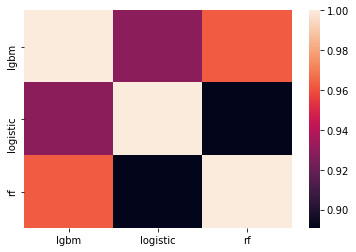

In [116]:
c_df = pd.DataFrame({'lgbm':result, 'logistic':result1, 'rf':rf_prob})
sns.heatmap(c_df.corr())

In [131]:
n_result = *c_df.logistic + *c_df.lgbm + *c_df.rf
n_result = np.int32(n_result > 1.5)
temp=pd.read_csv('test.csv')
submission={'PassengerId':temp.PassengerId,'Survived':n_result}
df_submission=pd.DataFrame(submission)
df_submission.to_csv('submission_22.csv', index=False)